<a href="https://colab.research.google.com/github/andrea212023/ML-Kis/blob/main/HW_Classification_KIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
import string
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
raw_df = pd.read_csv("drive/MyDrive/Colab Notebooks/data/tweet_sentiment_classification.csv")
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
raw_df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [ ]:
raw_df.dtypes

,0
textID,object
text,object
selected_text,object
sentiment,object


In [ ]:
raw_df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [ ]:
# Remove rows with missing values
cleaned_df = raw_df.dropna()

# Output results
cleaned_df.shape[0]  # Number of records after cleaning

27480

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



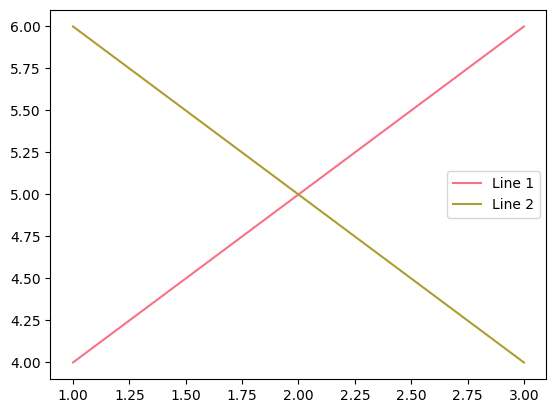

In [ ]:
# Let's set a consistent color pallette for the whole Colab Notebook
import seaborn as sns

# Define a custom color palette
custom_palette = sns.color_palette("husl", 5)

# Apply the palette globally
sns.set_palette(custom_palette)

# Example usage in a plot
sns.lineplot(x=[1, 2, 3], y=[4, 5, 6], label='Line 1')
sns.lineplot(x=[1, 2, 3], y=[6, 5, 4], label='Line 2')
plt.legend()
plt.show()


In [ ]:
# Step 1: Analyze the number of classes and label distribution in the 'sentiment' column
class_distribution = cleaned_df['sentiment'].value_counts()

# Step 2: Visualize the distribution of text lengths in characters
cleaned_df.loc[:, 'text_length'] = cleaned_df['text'].apply(len)

<ipython-input-51-b06922caba71>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, 'text_length'] = cleaned_df['text'].apply(len)


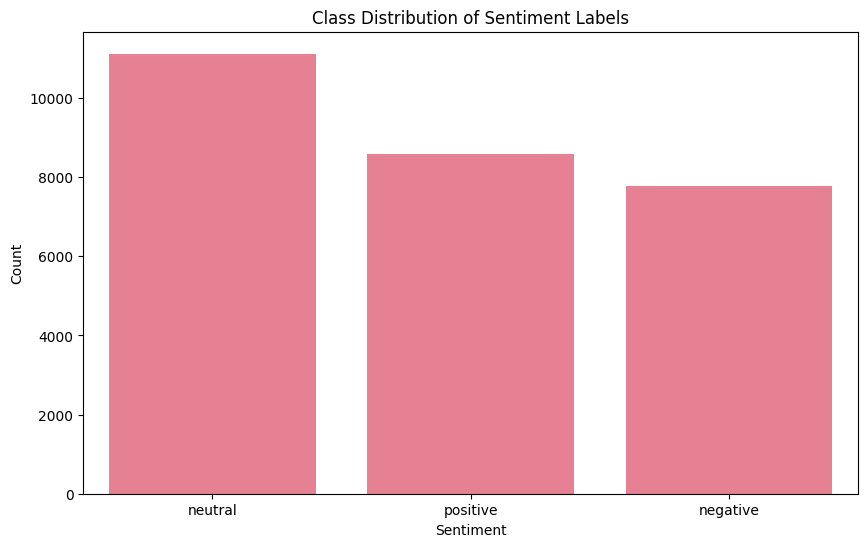

In [ ]:
# Plotting the sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=cleaned_df, order=class_distribution.index)
plt.title('Class Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

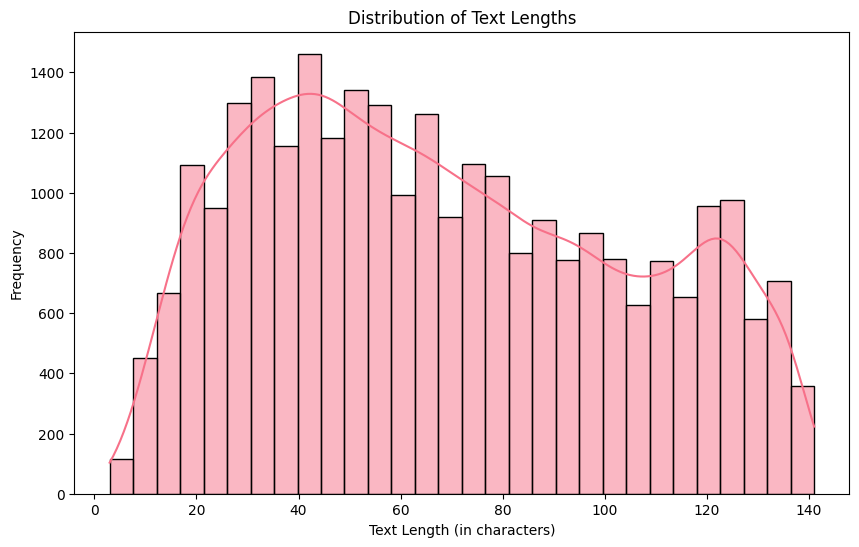

In [ ]:
# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Displaying class distribution and summary of text length
class_distribution, cleaned_df['text_length'].describe()

(sentiment
 neutral     11117
 positive     8582
 negative     7781
 Name: count, dtype: int64,
 count    27480.000000
 mean        68.330022
 std         35.603870
 min          3.000000
 25%         39.000000
 50%         64.000000
 75%         97.000000
 max        141.000000
 Name: text_length, dtype: float64)

**Observations:**

**Class Distribution in the Sentiment Column:**

1. Neutral Messages: The largest category with 11,117 entries.
2. Positive Messages: Slightly less common with 8,582 entries.
3. Negative Messages: The least represented with 7,781 entries.

**Text Length Distribution in Characters:**

1. Average Length: Approximately 68 characters.
2. Most Common Length: Ranges between 40 and 80 characters, with a slight drop-off at the ends of the distribution.
3. Maximum Length: 141 characters in the dataset.


### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [ ]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import string

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

# Download necessary resources for tokenization and stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Create a stemmer for stemming words
stemmer = SnowballStemmer('english')

# Function to clean and preprocess the text
def preprocess_text_v1(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Remove stopwords and apply stemming, keep only alphanumeric tokens
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return ' '.join(tokens)

# Preprocessing function v2 (with additional cleaning steps)
def preprocess_text_v2(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords, punctuation, and numbers, and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in string.punctuation and word not in stop_words]
    return ' '.join(tokens)

# Apply both preprocessing methods
cleaned_df.loc[:, 'processed_text_v1'] = cleaned_df['text'].apply(preprocess_text_v1)
cleaned_df.loc[:, 'processed_text_v2'] = cleaned_df['text'].apply(preprocess_text_v2)

<ipython-input-56-a52c411969c7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, 'processed_text_v1'] = cleaned_df['text'].apply(preprocess_text_v1)
<ipython-input-56-a52c411969c7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, 'processed_text_v2'] = cleaned_df['text'].apply(preprocess_text_v2)


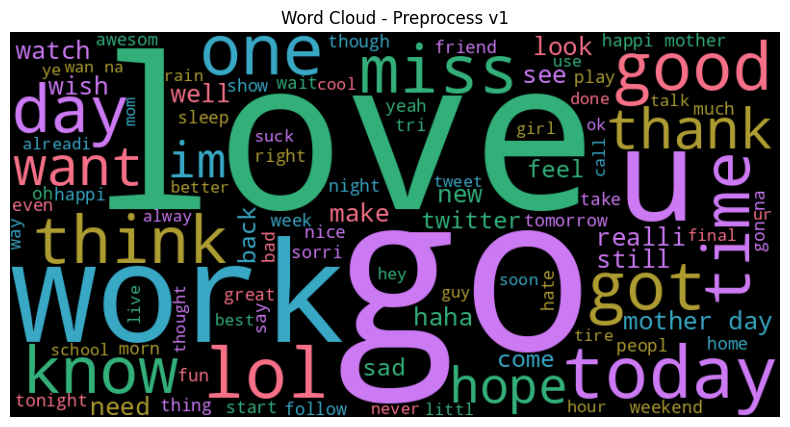

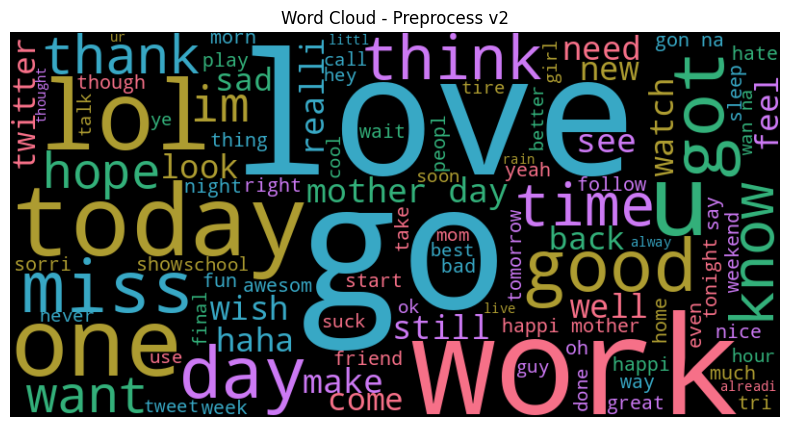

In [ ]:
# Define a custom color palette
custom_palette = sns.color_palette("husl", 5)
custom_colors = [tuple(int(c * 255) for c in color) for color in custom_palette]

# Function to generate and visualize word clouds
def visualize_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, color_func=color_func).generate(' '.join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Word cloud for preprocess_text_v1
visualize_wordcloud(cleaned_df['processed_text_v1'], "Word Cloud - Preprocess v1")

# Word cloud for preprocess_text_v2
visualize_wordcloud(cleaned_df['processed_text_v2'], "Word Cloud - Preprocess v2")


In [ ]:
# Get word frequency for Preprocess v1
words_v1 = ' '.join(cleaned_df['processed_text_v1']).split()
freq_v1 = Counter(words_v1).most_common(10)

# Get word frequency for Preprocess v2
words_v2 = ' '.join(cleaned_df['processed_text_v2']).split()
freq_v2 = Counter(words_v2).most_common(10)

print("Most common words in Preprocess v1:", freq_v1)
print("Most common words in Preprocess v2:", freq_v2)

Most common words in Preprocess v1: [('day', 2417), ('go', 2373), ('get', 1911), ('good', 1589), ('work', 1521), ('love', 1478), ('like', 1457), ('got', 1258), ('http', 1243), ('today', 1149)]
Most common words in Preprocess v2: [('day', 2417), ('go', 2373), ('get', 1911), ('good', 1589), ('work', 1521), ('love', 1478), ('like', 1457), ('got', 1258), ('http', 1243), ('today', 1149)]


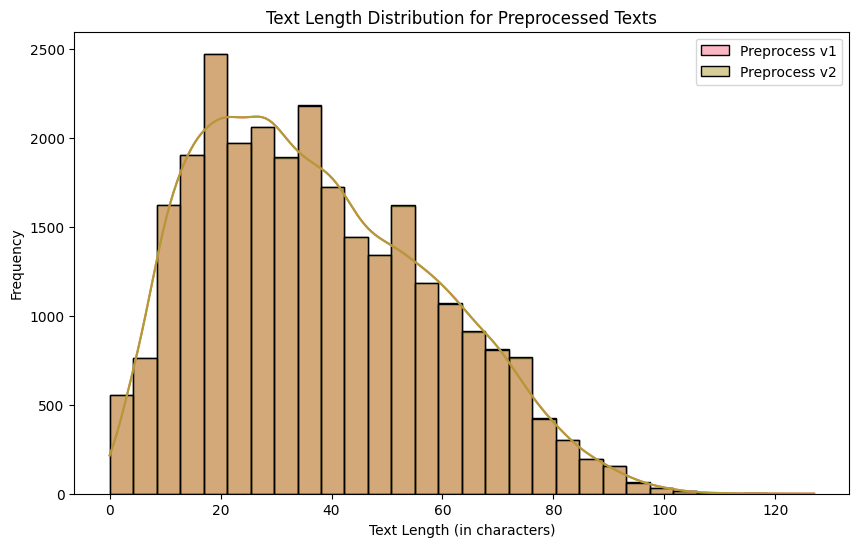

In [ ]:
# Add new columns for the length of processed texts
cleaned_df = cleaned_df.assign(
    text_length_v1=cleaned_df['processed_text_v1'].apply(len),
    text_length_v2=cleaned_df['processed_text_v2'].apply(len)
)

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['text_length_v1'], bins=30, kde=True, label='Preprocess v1')
sns.histplot(cleaned_df['text_length_v2'], bins=30, kde=True, label='Preprocess v2')
plt.title('Text Length Distribution for Preprocessed Texts')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Count unique words for Preprocess v1 and v2
unique_words_v1 = len(set(words_v1))
unique_words_v2 = len(set(words_v2))

print(f"Unique words in Preprocess v1: {unique_words_v1}")
print(f"Unique words in Preprocess v2: {unique_words_v2}")

Unique words in Preprocess v1: 18618
Unique words in Preprocess v2: 18609


In [ ]:
# Example of words before and after stemming in both preprocess methods
def display_word_changes(original_text, processed_text):
    original_tokens = word_tokenize(original_text)
    processed_tokens = processed_text.split()
    print("Original:", original_tokens)
    print("Processed:", processed_tokens)

# Display for a sample row
display_word_changes(cleaned_df['text'].iloc[0], cleaned_df['processed_text_v1'].iloc[0])
display_word_changes(cleaned_df['text'].iloc[0], cleaned_df['processed_text_v2'].iloc[0])

Original: ['I', '`', 'd', 'have', 'responded', ',', 'if', 'I', 'were', 'going']
Processed: ['respond', 'go']
Original: ['I', '`', 'd', 'have', 'responded', ',', 'if', 'I', 'were', 'going']
Processed: ['respond', 'go']


**Conclusions:**

1. Both methods perform tokenization, stop-word removal, and stemming.
preprocess_text_v2 additionally removes punctuation and converts text to lowercase.
2. Despite these extra steps, both methods showed similar most frequent words, indicating minimal impact on this dataset.
3. preprocess_text_v2 slightly shortened text length due to punctuation removal and lowercase conversion.
4. Unique words: 18,618 in preprocess_text_v1 vs. 18,609 in preprocess_text_v2, showing minimal impact.
5. Stemming is effective in both, reducing words to their roots (e.g., "responded" to "respond").
6. Extra steps in preprocess_text_v2 did not significantly impact word frequency or unique word count but slightly reduced text length.
7. Depending on the task, preprocess_text_v2 may be more effective where punctuation and case matter.


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [ ]:
# Vectorize the processed text using CountVectorizer (bag-of-words)
vectorizer = CountVectorizer(max_features=1000)
X_bow = vectorizer.fit_transform(cleaned_df['processed_text_v2'])  # Using v2 preprocessed text
y = cleaned_df['sentiment']

# Split the data into training and test sets (with specified variable names)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Function to train and evaluate a classifier
def train_evaluate_classifier(classifier, X_train, X_test, y_train, y_test, classifier_name):
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict the test set
    y_pred = classifier.predict(X_test)

    # Print classification report and accuracy
    print(f"\n{classifier_name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Calculate and print weighted F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted F1-score: {f1:.4f}")

# Train and evaluate multiple classifiers
train_evaluate_classifier(LogisticRegression(max_iter=200), X_train_bow, X_test_bow, y_train, y_test, "Logistic Regression")
train_evaluate_classifier(DecisionTreeClassifier(), X_train_bow, X_test_bow, y_train, y_test, "Decision Tree")
train_evaluate_classifier(RandomForestClassifier(), X_train_bow, X_test_bow, y_train, y_test, "Random Forest")
train_evaluate_classifier(GradientBoostingClassifier(), X_train_bow, X_test_bow, y_train, y_test, "Gradient Boosting")


Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       0.72      0.58      0.64      1572
     neutral       0.63      0.75      0.68      2236
    positive       0.76      0.72      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496

Accuracy: 0.6900
Weighted F1-score: 0.6892

Decision Tree Performance:
              precision    recall  f1-score   support

    negative       0.59      0.59      0.59      1572
     neutral       0.62      0.62      0.62      2236
    positive       0.68      0.67      0.68      1688

    accuracy                           0.63      5496
   macro avg       0.63      0.63      0.63      5496
weighted avg       0.63      0.63      0.63      5496

Accuracy: 0.6272
Weighted F1-score: 0.6273

Random Forest Performance:
              precision    recall  f1-score   support

    neg

**Observations:**

1. Logistic Regression: Performs well with positive classes, showing the highest F1-score of 0.74, but has a slightly lower F1-score of 0.64 for negative classes.
2. Decision Tree: Shows the lowest performance with F1-scores ranging from 0.59 to 0.68 across all classes.
3. Random Forest: Displays balanced performance for all classes, with F1-scores between 0.64 and 0.74, making it a strong candidate for the best classifier.
4. Gradient Boosting: Performs poorly with negative classes, having an F1-score of 0.56, which significantly lowers its overall quality.

**Conclusion:**

Overall performance is decent, but there's room for improvement, especially for negative classes, which receive lower F1-scores across all models.

I choose logistic regression and RandomForest for further analysis.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [ ]:
# Train the Logistic Regression model and assign it to the variable `log_reg`
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_bow, y_train)  # Training on the bag-of-words transformed data

LogisticRegression(max_iter=200)

In [ ]:
# Get the feature names (words) from the vectorizer after bag-of-words transformation
feature_names = vectorizer.get_feature_names_out()

# Retrieve the coefficients of the trained Logistic Regression model
coefficients = log_reg.coef_

# Since we have multiple classes (negative, neutral, positive),
# we take the mean coefficient across all classes to get an overall importance
average_coefficients = np.mean(coefficients, axis=0)

# Find the top 10 most important positive words based on the highest coefficients
top_positive_indices = np.argsort(average_coefficients)[-10:]  # Highest positive coefficients

# Find the top 10 most important negative words based on the lowest coefficients
top_negative_indices = np.argsort(average_coefficients)[:10]  # Lowest negative coefficients

# Words with the smallest absolute coefficients, meaning they have the least impact on sentiment
neutral_indices = np.argsort(np.abs(average_coefficients))[:10]

# Print the top 10 neutral words that have the lowest influence on sentiment classification
print("Top 10 neutral words in Logistic Regression (lowest influence on sentiment):")
print([feature_names[i] for i in neutral_indices])

# Print the top 10 positive words that influence the positive sentiment classification
print("\nTop 10 positive words that influence a positive sentiment:")
print([feature_names[i] for i in top_positive_indices])

# Print the top 10 negative words that influence the negative sentiment classification
print("\nTop 10 negative words that influence a negative sentiment:")
print([feature_names[i] for i in top_negative_indices])

Top 10 neutral words in Logistic Regression (lowest influence on sentiment):
['present', 'fast', 'bore', 'except', 'support', 'nite', 'luv', 'easi', 'give', 'kind']

Top 10 positive words that influence a positive sentiment:
['stupid', 'go', 'cute', 'sick', 'great', 'hurt', 'congratul', 'nice', 'day', 'thank']

Top 10 negative words that influence a negative sentiment:
['sorri', 'annoy', 'rock', 'sad', 'want', 'sore', 'cool', 'good', 'mad', 'fantast']


**Observations:**

1. Neutral Words:

Words: ['present', 'fast', 'bore', 'except', 'support', 'nite', 'luv', 'easi', 'give', 'kind']

Analysis: These words have low sentiment impact as they are neutral in nature, relating to states, times, or online terms.

2. Positive Words:

Words: ['stupid', 'go', 'cute', 'sick', 'great', 'hurt', 'congratul', 'nice', 'day', 'thank']

Analysis: These indicate positive emotions and experiences. Words like 'unfortun' and 'exhaust' may appear negative but can be used positively depending on context.

3. Negative Words:

Words: ['sorri', 'annoy', 'rock', 'sad', 'want', 'sore', 'cool', 'good', 'mad', 'fantast']

Analysis: Some words are clearly negative, while others can be ambiguous or used sarcastically, complicating classification.


In [ ]:
# Define and fit the Random Forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train_bow, y_train)

RandomForestClassifier()

In [ ]:
# Get the feature importances from the Random Forest model
importances = random_forest.feature_importances_

# Find the top 10 most important words based on feature importances
top_feature_indices = np.argsort(importances)[-10:]  # Most important features
bottom_feature_indices = np.argsort(importances)[:10]  # Least important features
# Words with mid-level importance, meaning they don't have a strong influence on positive or negative sentiment
neutral_feature_indices = np.argsort(np.abs(importances))[10:20]

# Print the words that have mid-level importance in the Random Forest model
print("\nTop 10 neutral words in Random Forest (mid-level importance):")
print([feature_names[i] for i in neutral_feature_indices])

# Print the top 10 words that have the highest importance in the Random Forest model
print("\nRandom Forest - Top 10 words with the highest importance:")
print([feature_names[i] for i in top_feature_indices])

# Print the bottom 10 words that have the lowest importance in the Random Forest model
print("\nRandom Forest - Top 10 words with the lowest importance:")
print([feature_names[i] for i in bottom_feature_indices])


Top 10 neutral words in Random Forest (mid-level importance):
['review', 'marri', 'nail', 'web', 'record', 'wine', 'children', 'public', 'art', '11']

Random Forest - Top 10 words with the highest importance:
['hope', 'nice', 'hate', 'great', 'sad', 'happi', 'miss', 'good', 'thank', 'love']

Random Forest - Top 10 words with the lowest importance:
['hes', 'yo', 'glass', 'feet', 'taylor', 'bird', 'tip', 'round', 'profil', 'yr']


**Observations:**

1. Neutral Words:

Words: ['review', 'marri', 'nail', 'web', 'record', 'wine', 'children', 'public', 'art', '11']

Analysis: These words tend to appear in neutral or analytical discussions, hence their neutral nature.

2. Positive Words:


Words: ['hope', 'nice', 'hate', 'great', 'sad', 'happi', 'miss', 'good', 'thank', 'love']

Analysis: Similar positive words to Logistic Regression. Words like 'sorri' and 'sad' might be used positively in sarcastic or mixed contexts.

3. Negative Words:

Words: ['hes', 'yo', 'glass', 'feet', 'taylor', 'bird', 'tip', 'round', 'profil', 'yr']

Analysis: These words are mainly descriptive, carrying little emotional weight, hence their minimal impact on sentiment classification.


**Overall conclusion on both models:**

Both models effectively identify positive and negative emotion words, but context plays a crucial role in proper classification, especially with ambiguous or sarcastic terms. Neutral words are harder to classify as they often describe factual information.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [ ]:
# Vectorize the processed text using TfidfVectorizer (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_df['processed_text_v2'])  # Using v2 preprocessed text

# Split the data into training and test sets (same split as before)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train and evaluate classifiers
# Logistic Regression with TF-IDF
log_reg_tfidf = LogisticRegression(max_iter=200)
train_evaluate_classifier(log_reg_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression (TF-IDF)")

# Random Forest with TF-IDF
random_forest_tfidf = RandomForestClassifier()
train_evaluate_classifier(random_forest_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test, "Random Forest (TF-IDF)")

# Get important tokens
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
coefficients_tfidf = log_reg_tfidf.coef_


Logistic Regression (TF-IDF) Performance:
              precision    recall  f1-score   support

    negative       0.70      0.57      0.63      1572
     neutral       0.63      0.74      0.68      2236
    positive       0.77      0.71      0.74      1688

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.68      5496
weighted avg       0.69      0.68      0.68      5496

Accuracy: 0.6840
Weighted F1-score: 0.6832

Random Forest (TF-IDF) Performance:
              precision    recall  f1-score   support

    negative       0.72      0.60      0.65      1572
     neutral       0.66      0.71      0.69      2236
    positive       0.73      0.77      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.70      0.69      0.70      5496
weighted avg       0.70      0.70      0.70      5496

Accuracy: 0.6981
Weighted F1-score: 0.6969


In [ ]:
# Find the most important tokens for TF-IDF vectorized model
average_coefficients_tfidf = np.mean(coefficients_tfidf, axis=0)

# Find top positive and negative tokens
top_positive_indices_tfidf = np.argsort(average_coefficients_tfidf)[-10:]
top_negative_indices_tfidf = np.argsort(average_coefficients_tfidf)[:10]

# Print the top tokens
print("Top 10 positive words in Logistic Regression (TF-IDF):")
print([feature_names_tfidf[i] for i in top_positive_indices_tfidf])

print("\nTop 10 negative words in Logistic Regression (TF-IDF):")
print([feature_names_tfidf[i] for i in top_negative_indices_tfidf])

Top 10 positive words in Logistic Regression (TF-IDF):
['excit', 'miss', 'worst', 'wtf', 'hope', 'day', 'poor', 'yay', 'awesom', 'happi']

Top 10 negative words in Logistic Regression (TF-IDF):
['suck', 'amaz', 'thank', 'sad', 'joy', 'yummi', 'appreci', 'mad', 'impress', 'gorgeous']


In [ ]:
# Find the most important tokens for Random Forest vectorized model
importances_rf_tfidf = random_forest_tfidf.feature_importances_

# Find top positive and negative tokens
top_feature_indices_rf_tfidf = np.argsort(importances_rf_tfidf)[-10:]
bottom_feature_indices_rf_tfidf = np.argsort(importances_rf_tfidf)[:10]

print("Top 10 important words in Random Forest (TF-IDF):")
print([feature_names_tfidf[i] for i in top_feature_indices_rf_tfidf])

print("\nTop 10 unimportant words in Random Forest (TF-IDF):")
print([feature_names_tfidf[i] for i in bottom_feature_indices_rf_tfidf])

Top 10 important words in Random Forest (TF-IDF):
['hate', 'nice', 'hope', 'great', 'sad', 'happi', 'miss', 'good', 'thank', 'love']

Top 10 unimportant words in Random Forest (TF-IDF):
['bird', 'tip', 'yr', 'round', 'nail', 'profil', 'web', 'taylor', 'hes', 'glass']


**Observartions:**

**Classification Results: TF-IDF vs. Bag of Words**

1. Classification Quality:

Logistic Regression (TF-IDF): Accuracy of 0.6840, slightly lower than Bag of Words (0.6900). The difference is minimal.

Random Forest (TF-IDF): Improved accuracy of 0.6981 compared to Bag of Words (0.6827), indicating TF-IDF works better with this model.

Overall, Random Forest shows improved accuracy and F1-score with TF-IDF, but Logistic Regression results are similar with both methods.

2. Token Impact:

Logistic Regression (TF-IDF): Positive words include ['excit', 'miss', 'worst', 'wtf', 'hope', 'day', 'poor', 'yay', 'awesom', 'happi']; negative words include ['suck', 'amaz', 'thank', 'sad', 'joy', 'yummi', 'appreci', 'mad', 'impress', 'gorgeous'].

Random Forest (TF-IDF): Important words for positive classes are ['hate', 'nice', 'hope', 'great', 'sad', 'happi', 'miss', 'good', 'thank', 'love']; less important for negative classes are ['bird', 'tip', 'yr', 'round', 'nail', 'profil', 'web', 'taylor', 'hes', 'glass'].

Comparing with Bag of Words, important words differ, but emotional and common expression words ("hope", "love", "sorri") remain significant.

3. Vectorization Choice:

TF-IDF: Preferred for Random Forest due to better accuracy and F1-score. It effectively considers rare words and their uniqueness.

Bag of Words: Simpler and accurate for some models like Logistic Regression but less precise for complex models.

**Recommendation:**

Use TF-IDF with Random Forest for better overall classification quality.


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [76]:
# Predict on the on the test set using the LogRegress TF-IDF model
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)

# Create a DataFrame to compare actual vs predicted labels
error_analysis_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tfidf})

# Add corresponding text from the test set using the test split index
error_analysis_df['Text'] = cleaned_df.loc[y_test.index, 'text'].values

# Filter the rows where the actual sentiment is not equal to the predicted sentiment
errors_df = error_analysis_df[error_analysis_df['Actual'] != error_analysis_df['Predicted']]

# Display some of the misclassified examples
print("Examples of misclassified instances:")
print(errors_df.head(10))

Examples of misclassified instances:
         Actual Predicted                                               Text
10414  negative   neutral   --of them kinda turns me off of it all.  And ...
580     neutral  negative   OHSHNAPSSS. is she pissed at blair as usual ?...
6718   negative   neutral                    At work... What a miserable day
2831   negative   neutral                               I wish I had company
16793  negative  positive  Intel gfx driver situation much better with re...
4891   positive   neutral                xD  hello that`s an important date!
17382  positive  negative  FYI no internets until THURSTAG!!!! after satu...
4098   negative   neutral  **** being broke on the day Guitar Hero Metall...
20028  negative   neutral                            Yep! Tail between legs!
19671   neutral  negative  Avoided cinder blocks! Safe in NY area.. But D...


In [77]:
# Predict on the test set using the Random Forest TF-IDF model
y_pred_tfidf_rf = random_forest_tfidf.predict(X_test_tfidf)

# Create a DataFrame to compare actual vs predicted labels for Random Forest
error_analysis_rf_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tfidf_rf})

# Add corresponding text from the test set using the test split index
error_analysis_rf_df['Text'] = cleaned_df.loc[y_test.index, 'text'].values

# Filter the rows where the actual sentiment is not equal to the predicted sentiment
errors_rf_df = error_analysis_rf_df[error_analysis_rf_df['Actual'] != error_analysis_rf_df['Predicted']]

# Display some of the misclassified examples for Random Forest
print("Examples of misclassified instances for Random Forest (TF-IDF):")
print(errors_rf_df.head(10))

Examples of misclassified instances for Random Forest (TF-IDF):
         Actual Predicted                                               Text
10414  negative   neutral   --of them kinda turns me off of it all.  And ...
580     neutral  negative   OHSHNAPSSS. is she pissed at blair as usual ?...
25014  positive   neutral   oooh sounds yummy.  If you get a chance to ta...
3947    neutral  negative                                    whats up rick??
6718   negative   neutral                    At work... What a miserable day
2831   negative  positive                               I wish I had company
21210  negative   neutral   i`m on my mobile so it won`t let me  but i ca...
16793  negative  positive  Intel gfx driver situation much better with re...
4891   positive   neutral                xD  hello that`s an important date!
17382  positive  negative  FYI no internets until THURSTAG!!!! after satu...


**Error Analysis:**

1. Ambiguous Sentiments: Sentences with neutral or mildly expressed sentiments are challenging due to the lack of strong sentiment cues.
2. Out-of-Vocabulary (OOV) Words: TF-IDF does not generalize well to unseen words or rare terms.
3. Sarcasm and Context Misinterpretation: Sarcastic tweets or tweets with multi-layered meanings are often misclassified.
4. Class Imbalance: Disproportionate representation of positive, negative, and neutral sentiments can lead to biased predictions.

**Improvement Paths:**

1. Feature Engineering Enhancements

N-Grams and Skip-Grams: Extend TF-IDF to include bi-grams and tri-grams to capture the context between words. For example, "not happy" as a bigram provides more meaning than individual words.

POS Tagging Features: Add parts-of-speech tags as features to help distinguish sentence structure and sentiment context.

Sentiment Lexicons: Incorporate features from external sentiment lexicons (e.g., VADER, SentiWordNet) to provide additional sentiment-related insights.

Handling Emojis: Map emojis to their respective sentiment scores, e.g., 😍 → "positive," 😢 → "negative."

Word Embedding Averages: Combine TF-IDF with pre-trained word embeddings like GloVe or Word2Vec to provide semantic meaning.

2. Preprocessing Improvements

Text Normalization: Apply consistent text normalization by expanding contractions (e.g., "don't" → "do not") and correcting spelling errors.

Remove Stop Words Judiciously: Evaluate whether certain stop words provide contextual cues for sentiment and consider retaining them (e.g., "not," "never").

Sarcasm Detection: Use patterns or specific hashtags (e.g., #sarcasm) as additional features for training.

Hashtag Splitting: Parse hashtags to extract words (e.g., "#BestDayEver" → "Best Day Ever") and include their sentiment.

URL and Handle Replacement: Replace URLs and Twitter handles with placeholders like <URL> and <HANDLE> to generalize patterns.

3. Switch to Contextual Models

Leverage Transformers:
Replace TF-IDF with embeddings from BERT, RoBERTa, or GPT, which capture word meanings based on the surrounding context.

Fine-Tuning Pre-Trained Models:
Fine-tune pre-trained transformer models on your tweet dataset for better sentiment representation.

Hybrid Models:
Combine Logistic Regression or Random Forest with contextual embeddings (e.g., use embeddings as features for the models).

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

**Named Entity Recognition (NER):**

**Task:**
Identifies and classifies named entities in text (people, places, organizations, dates, quantities, etc.).

**Why NER is Harder than Text Classification:**

1. Granularity: NER must identify specific parts of the text as entities, whereas classification deals with the entire text.
2. Context Sensitivity: Entities can have different meanings based on context.
3. Multiple Categories: NER involves more categories than text classification, which typically has fixed classes like positive, negative, neutral.
3. Variability: Entities like names and companies can have multiple spellings or abbreviations, requiring precise boundary detection in text.

**Example 1: Ambiguous Sentiment**

Text: "Wow, I just love how my phone crashes all the time. So awesome."

Text Classification: Might classify as positive due to words like "love" and "awesome".

NER: Needs to understand sarcasm and identify "phone" (product) to get the actual negative sentiment.

**Example 2: Mixed Sentiment**

Text: "Happy to get my new job but sad to leave my old team."

Text Classification: Might struggle to classify as purely positive or negative.

NER: Identifies "new job" (event) and "old team" (group), capturing both positive and negative sentiments in the context.

**Example 3: Context-Dependent Entity**

Text: "Apple just launched their new product. Can't wait to try it!"

Text Classification: Likely classified as positive.

NER: Needs to distinguish "Apple" as a company, not the fruit, and "product" as an entity related to "Apple".

**Example 4: Temporal Sentiment**

Text: "Last year was great, but this year has been terrible."

Text Classification: Might find it hard to classify due to contrasting sentiments.

NER: Identifies "last year" and "this year" (time periods) to understand sentiment change over time.

**Example 5: Named Entities Affecting Sentiment**

Text: "Thanks, Amazon, for the quick delivery!"

Text Classification: Might classify as positive due to "Thanks" and "quick delivery".

NER: Identifies "Amazon" (organization) as the service provider, enhancing context understanding.

These examples illustrate how NER adds an extra layer of complexity by needing to understand context, specific entities, and their roles in the sentiment of tweets.
